In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
fn_results = "../results/results_no_gams.parquet"
map_countries = {
    "FR": "France",
    "DE": "Germany",
    "GR": "Greece",
}

In [21]:
df_in = pd.read_parquet(fn_results)
df_in.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104068800 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   pv                    float64
 1   wind                  float64
 2   demand                float64
 3   base                  float64
 4   supply                float64
 5   netSupply             float64
 6   initialStorageLevel   float64
 7   storageLevel          float64
 8   MAX_STO               float64
 9   shareWind             float64
 10  renewableDemandShare  float64
 11  country               object 
 12  yearWeather           int64  
 13  yearDemand            int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 11.6+ GB


In [22]:
# df_agg = (
#     df_in
#     .groupby(["country", "renewableDemandShare", "yearWeather", "yearDemand"], as_index=False)
#     [["MAX_STO", "shareWind", "sharePv", "curtailmentBase", "curtailmentWind", "curtailmentPv"]]
#     .mean()
#     .assign(
#         # convert to percentage and set RE share to zero for non-renewable scenarios
#         shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
#         sharePv=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["sharePv"] * 100,
#         renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
#     )
#     .round(2)
#)

df_agg = (
    df_in
    .groupby(["country", "renewableDemandShare", "yearWeather", "yearDemand"], as_index=False)
    [["MAX_STO", "shareWind"]]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
    )
    .round(2)
)

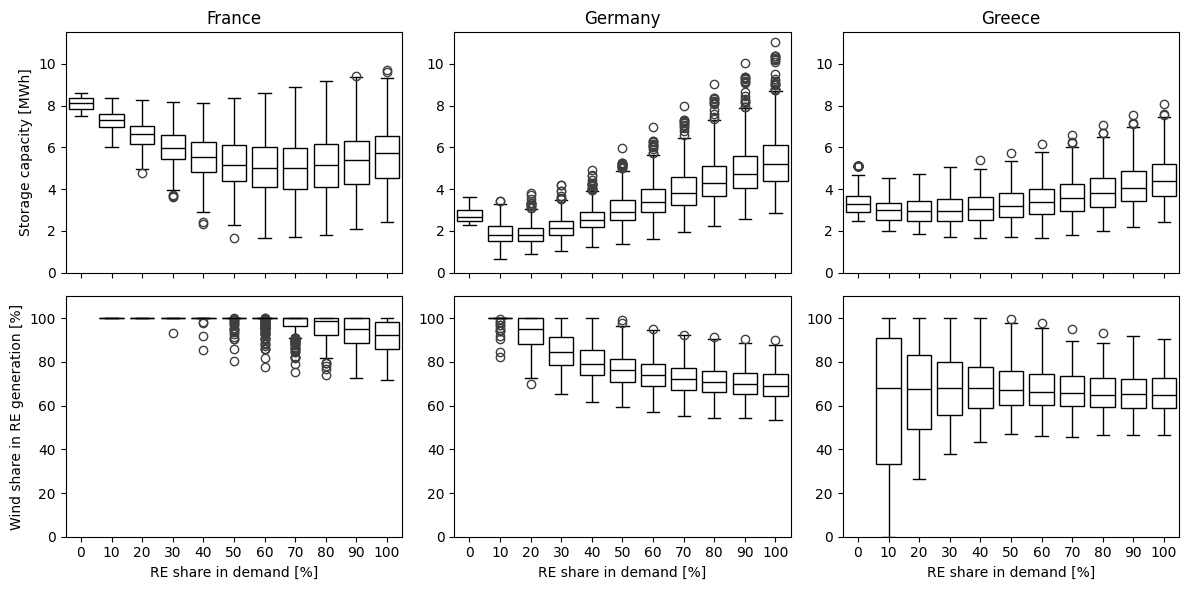

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
df_agg["country"].unique()
for i, country in enumerate(["FR", "DE", "GR"]):
    ax = axs[0, i]
    df_p = df_agg.query(f"country == '{country}'") 
    sns.boxplot(
        df_p, 
        x="renewableDemandShare",
        y="MAX_STO",
        ax=ax,
        **PROPS
    )
    ax.set_ylim(0, 11.5)
    if i == 0:
        ax.set_ylabel("Storage capacity [MWh]")
    else:
        ax.set_ylabel("")
    
    ax.set_title(map_countries[country])
    ax = axs[1, i]
    sns.boxplot(
        df_p[df_p["renewableDemandShare"] > 0], 
        x="renewableDemandShare",
        y="shareWind",
        ax=ax,
        **PROPS
    )
    if i == 0:
        ax.set_ylabel("Wind share in RE generation [%]")
    else:
        ax.set_ylabel("")
    ax.set_ylim(0, 110)
    ax.set_xlabel("RE share in demand [%]")
plt.tight_layout()
plt.savefig("../results/storage_capacity_and_wind_share.png", dpi=300)
    